In [345]:
import pyxdf
import mne
from mne.decoding import CSP
from mne.preprocessing import EOGRegression
from mne.stats import permutation_cluster_1samp_test as pcluster_test
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score,classification_report
from sklearn.model_selection import train_test_split

from mnetools import streams2mnedata, preprocessing

In [346]:
# -- |Data details| --
participant_id = 2
session = 2
# -- |Data Selection| --
initial_run = 3
n_run = 5

# -- |Parameters| --
tmin= -0.5
tmax= 3

# -- |Event dictionary| --
# Set up your event name
if session == 1 : events_id = {'right': 0, 'left': 1}
else            : events_id = {'none': 0, 'right': 1, 'left': 2}

# **Raw Data Overview**

In [347]:
# -- |Local parameters|--
epochs_list = [] 

for i in range(initial_run,initial_run+n_run):
    # -- |File import| --
    streams, header = pyxdf.load_xdf(f"Data/sub-P{participant_id:003d}/ses-S{session:003d}/eeg/sub-P{participant_id:003d}_ses-S{session:003d}_task-Default_run-{i:003d}_eeg.xdf") #Example Data from Lab Recoder

    raw_mne, events = streams2mnedata(streams)
    epochs = mne.Epochs(raw_mne, events, tmin= -0.5,  tmax= 3, event_id = events_id, preload = True,verbose=False,picks = ['C3','Cz','C4','PO7','Pz','PO8','EOG'])

    epochs_list.append(epochs)

epochs = mne.concatenate_epochs(epochs_list)
epochs.set_montage(mne.channels.make_standard_montage('standard_1020'))

Number of events,228
Events,left: 75none: 78right: 75
Time range,-0.500 – 3.000 s
Baseline,-0.500 – 0.000 s


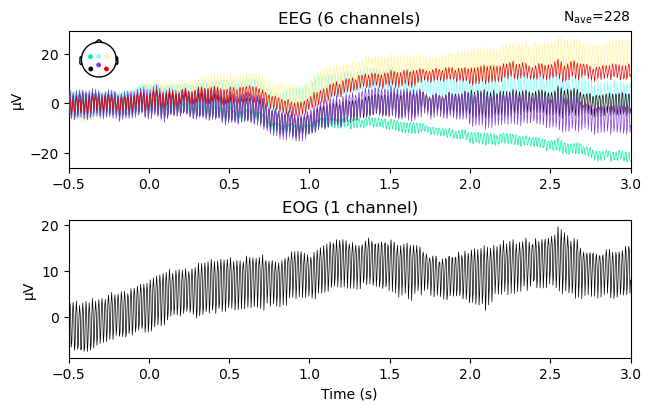

In [348]:
plot_kwargs = dict(picks="all")

# plot the evoked for the EEG and the EOG sensors
fig = epochs.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_22620\3855270505.py:1: FutureWarning: The value of `amplitude='auto'` will be removed in MNE 1.8.0, and the new default will be `amplitude=False`.
  epochs.compute_psd(fmin=0,fmax=50).plot()
c:\Users\AbsoluteZeno\anaconda3\Lib\site-packages\mne\viz\utils.py:167: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


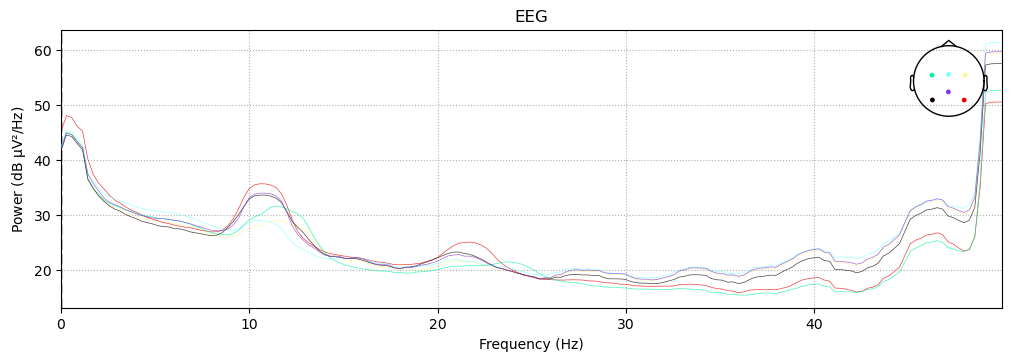

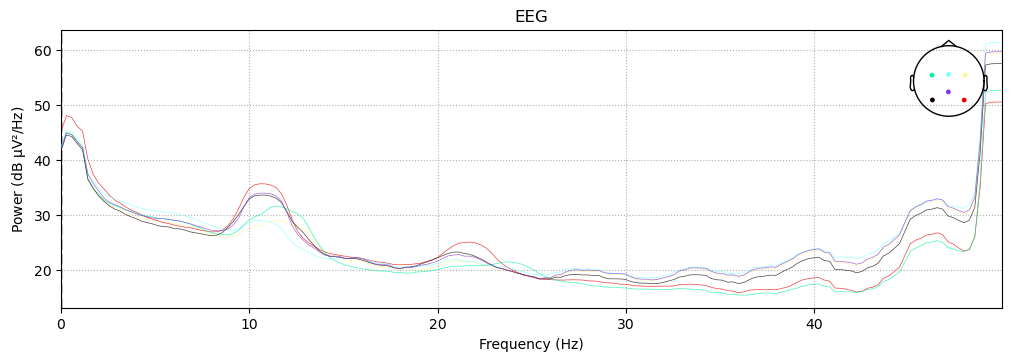

In [349]:
epochs.compute_psd(fmin=0,fmax=50).plot()

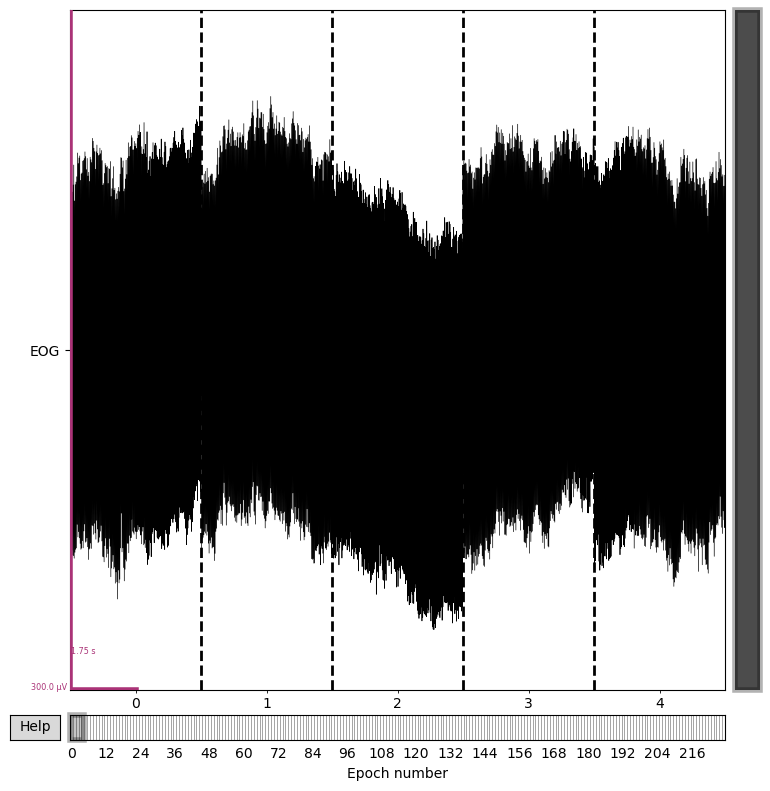

In [350]:
epochs.plot(picks='EOG', n_epochs=5);

# **Processing**

In [352]:
# -- |Local parameters|--
epochs_list = [] 

for i in range(initial_run,initial_run+n_run):
    # -- |File import| --
    streams, header = pyxdf.load_xdf(f"Data/sub-P{participant_id:003d}/ses-S{session:003d}/eeg/sub-P{participant_id:003d}_ses-S{session:003d}_task-Default_run-{i:003d}_eeg.xdf") #Example Data from Lab Recoder

    raw_mne, events = streams2mnedata(streams)
    prepro_mne = preprocessing(raw_mne)
    
    # -- |Epoch Segmentation| --
    epochs = mne.Epochs(prepro_mne, events, tmin= tmin,  tmax= tmax, event_id = events_id, preload = True,verbose=False,picks = ['C3','Cz','C4','PO7','Pz','PO8','EOG'])

    epochs_list.append(epochs)

epochs = mne.concatenate_epochs(epochs_list)
epochs.set_montage(mne.channels.make_standard_montage('standard_1020'))

Number of events,228
Events,left: 75none: 78right: 75
Time range,-0.500 – 3.000 s
Baseline,-0.500 – 0.000 s


## Part 1: Without artifact removal

### 1.1 Left vs. Right Classification

#### 1.1.1 SVM

Train set shape: (120, 7)
Test set shape : (30, 7)


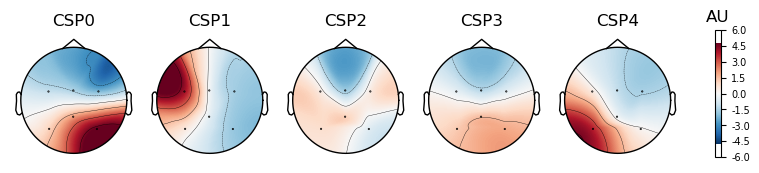

Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

       right       0.92      0.73      0.81        15
        left       0.78      0.93      0.85        15

    accuracy                           0.83        30
   macro avg       0.85      0.83      0.83        30
weighted avg       0.85      0.83      0.83        30



In [353]:
mne.set_log_level(verbose=False)

# Get EEG data and events
X = epochs[['right','left']].get_data(copy=False)
Y = epochs[['right','left']].events[:, -1]

csp_list = []
svm_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    svm = Pipeline([('SVM', SVC(kernel='linear'))])  
    svm.fit(X_train, Y_train)
    svm_list.append(svm)

    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['right', 'left'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

#### 1.1.2 Logistic Regression

Train set shape: (120, 7)
Test set shape : (30, 7)


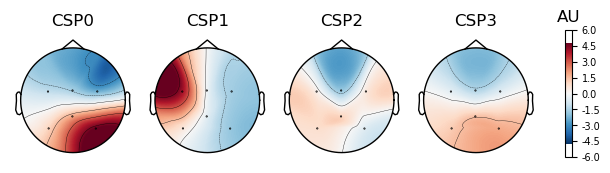

Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

  none-right       0.92      0.73      0.81        15
       right       0.78      0.93      0.85        15

    accuracy                           0.83        30
   macro avg       0.85      0.83      0.83        30
weighted avg       0.85      0.83      0.83        30



In [354]:
csp_list = []
lr_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    lr = Pipeline([('LR', LogisticRegression())])
    lr.fit(X_train, Y_train)
    lr_list.append(lr)

    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
lr = lr_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

In [355]:
timewindow = np.full((7,500),1e-15)
channels = ['C3','Cz','C4','Pz','PO7','PO8','EOG'] # Set your target EEG channel name
info = mne.create_info(
    ch_names= channels,
    ch_types= ['eeg']*(len(channels) - 1) + ['eog'],
    sfreq= 250,  # OpenBCI Frequency acquistion
    verbose=False
)

In [356]:
sample = [np.random.rand(), np.random.rand(), np.random.rand(), np.random.rand(), np.random.rand(), np.random.rand(), np.random.rand(), np.random.rand()]
timewindow = np.concatenate([timewindow[:,1:], (np.array([sample[1:]])/1000000).T], axis=1)
timewindow_mne = mne.io.RawArray(timewindow, info, verbose=False)
timewindow_mne = preprocessing(timewindow_mne)

realtime_data = timewindow_mne.get_data()[:,-int((tmax-tmin)*250):]
realtime_data = realtime_data - np.array([np.mean(realtime_data[:int((0-tmin)*250)], axis = 1)]).T
realtime_data

array([[ 4.98561903e-10,  4.98561903e-10,  4.98561903e-10, ...,
        -3.33696883e-08, -1.71100131e-08,  4.98561903e-10],
       [-2.98253488e-10, -2.98253488e-10, -2.98253488e-10, ...,
         1.99626683e-08,  1.02356820e-08, -2.98253488e-10],
       [-1.37112000e-09, -1.37112000e-09, -1.37112000e-09, ...,
         9.17716467e-08,  4.70551017e-08, -1.37112000e-09],
       ...,
       [-9.37951443e-10, -9.37951443e-10, -9.37951443e-10, ...,
         6.27788586e-08,  3.21893056e-08, -9.37951443e-10],
       [ 1.63004704e-09,  1.63004704e-09,  1.63004704e-09, ...,
        -1.09102122e-07, -5.59411500e-08,  1.63004704e-09],
       [ 1.61015174e-09,  1.61015174e-09,  1.61015174e-09, ...,
        -1.07770492e-07, -5.52583685e-08,  1.61015174e-09]])

In [357]:
a = np.random.rand(5,6)
print(a,np.mean(a, axis = 1),a - np.array([np.mean(a, axis = 1)]).T)

[[0.38719568 0.90003494 0.77077216 0.77529654 0.31702095 0.82056771]
 [0.23077898 0.7200072  0.96444988 0.56634749 0.21890937 0.98214351]
 [0.3468631  0.54786314 0.05344577 0.08080963 0.8891715  0.24253834]
 [0.41041699 0.31839625 0.81436838 0.28599961 0.21654922 0.4363669 ]
 [0.89050841 0.63384259 0.49962925 0.97043457 0.00552305 0.29144218]] [0.66181466 0.61377274 0.36011525 0.41368289 0.54856334] [[-0.27461899  0.23822028  0.10895749  0.11348188 -0.34479371  0.15875305]
 [-0.38299375  0.10623446  0.35067714 -0.04742525 -0.39486337  0.36837077]
 [-0.01325214  0.18774789 -0.30666948 -0.27930561  0.52905625 -0.11757691]
 [-0.0032659  -0.09528664  0.40068549 -0.12768328 -0.19713368  0.02268401]
 [ 0.34194507  0.08527925 -0.04893409  0.42187123 -0.54304029 -0.25712116]]


### 1.2 Left vs. Non-left Classification

#### 1.2.1 SVM

Train set shape: (182, 7)
Test set shape : (46, 7)


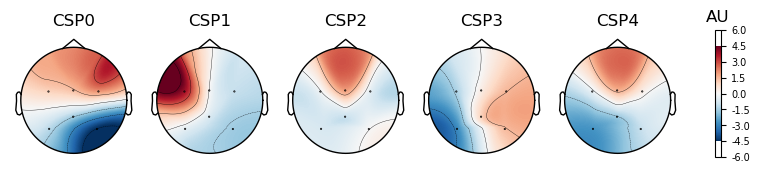

Accuracy: 0.8043478260869565
              precision    recall  f1-score   support

   none-left       0.82      0.90      0.86        31
        left       0.75      0.60      0.67        15

    accuracy                           0.80        46
   macro avg       0.79      0.75      0.76        46
weighted avg       0.80      0.80      0.80        46



In [358]:
epochs_l = epochs.copy()
epochs_l.events = mne.merge_events(epochs_l.events, [0, 1], 0, replace_events=True)
epochs_l.event_id = {'none-left': 0, 'left': 2}

# Get EEG data and events
X = epochs_l.get_data(copy=False)
Y = epochs_l.events[:, -1]

csp_list = []
svm_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    svm = Pipeline([('SVM', SVC(kernel='linear'))])  
    svm.fit(X_train, Y_train)
    svm_list.append(svm)

    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-left', 'left'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

#### 1.2.2 Logistic Regression

Train set shape: (182, 7)
Test set shape : (46, 7)


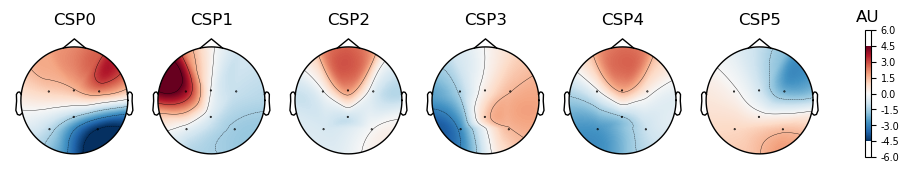

Accuracy: 0.8478260869565217
              precision    recall  f1-score   support

  none-right       0.85      0.94      0.89        31
       right       0.83      0.67      0.74        15

    accuracy                           0.85        46
   macro avg       0.84      0.80      0.82        46
weighted avg       0.85      0.85      0.84        46



In [359]:
csp_list = []
lr_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    lr = Pipeline([('LR', LogisticRegression())])
    lr.fit(X_train, Y_train)
    lr_list.append(lr)

    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
lr = lr_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

### 1.3 Right vs. Non-Right Classification

#### 1.3.1 SVM

Train set shape: (182, 7)
Test set shape : (46, 7)


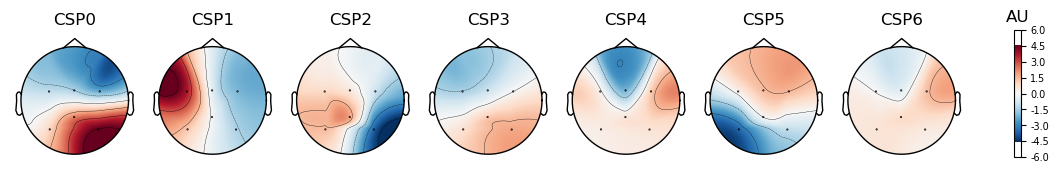

Accuracy: 0.782608695652174
              precision    recall  f1-score   support

  none-right       0.78      0.94      0.85        31
       right       0.78      0.47      0.58        15

    accuracy                           0.78        46
   macro avg       0.78      0.70      0.72        46
weighted avg       0.78      0.78      0.77        46



In [360]:
epochs_r = epochs.copy()
epochs_r.events = mne.merge_events(epochs_r.events, [0, 2], 0, replace_events=True)
epochs_r.event_id = {'none-right': 0, 'right': 1}

# Get EEG data and events
X = epochs_r.get_data(copy=False)
Y = epochs_r.events[:, -1]

csp_list = []
svm_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    svm = Pipeline([('SVM', SVC(kernel='linear'))])  
    svm.fit(X_train, Y_train)
    svm_list.append(svm)

    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

#### 1.3.2 Logistic Regression

Train set shape: (182, 7)
Test set shape : (46, 7)


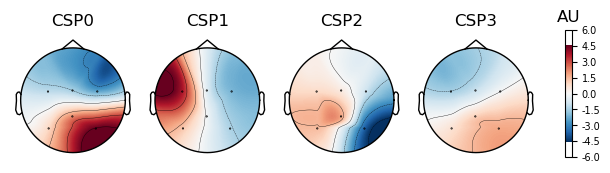

Accuracy: 0.7391304347826086
              precision    recall  f1-score   support

  none-right       0.77      0.87      0.82        31
       right       0.64      0.47      0.54        15

    accuracy                           0.74        46
   macro avg       0.70      0.67      0.68        46
weighted avg       0.73      0.74      0.73        46



In [361]:
csp_list = []
lr_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    lr = Pipeline([('LR', LogisticRegression())])
    lr.fit(X_train, Y_train)
    lr_list.append(lr)

    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
lr = lr_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

## Part 2: With artifact removal

### Artifact Correlations

C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_22620\2921723998.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+alpha)
C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_22620\2921723998.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+alpha)


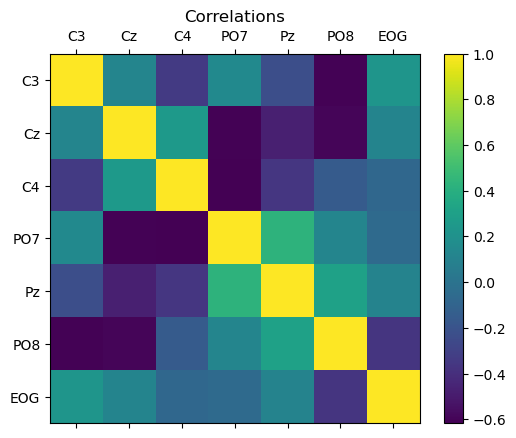

,C3,Cz,C4,PO7,Pz,PO8,EOG
C3,1.000000,0.116842,-0.340120,0.148844,-0.227838,-0.608505,0.224793
Cz,0.116842,1.000000,0.257895,-0.604446,-0.472464,-0.595325,0.114139
C4,-0.340120,0.257895,1.000000,-0.616741,-0.363645,-0.153517,-0.078859
PO7,0.148844,-0.604446,-0.616741,1.000000,0.425769,0.116168,-0.060262
Pz,-0.227838,-0.472464,-0.363645,0.425769,1.000000,0.308979,0.106482
PO8,-0.608505,-0.595325,-0.153517,0.116168,0.308979,1.000000,-0.368715
EOG,0.224793,0.114139,-0.078859,-0.060262,0.106482,-0.368715,1.000000


In [362]:
df = epochs.to_data_frame()
df_numerical = df[epochs.ch_names]

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(df_numerical.corr(), interpolation='nearest')
fig.colorbar(cax)

alpha = epochs.ch_names
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)
ax.set_title('Correlations')

plt.show()
df_numerical.corr()

C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_22620\3594465532.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+alpha)
C:\Users\AbsoluteZeno\AppData\Local\Temp\ipykernel_22620\3594465532.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+alpha)


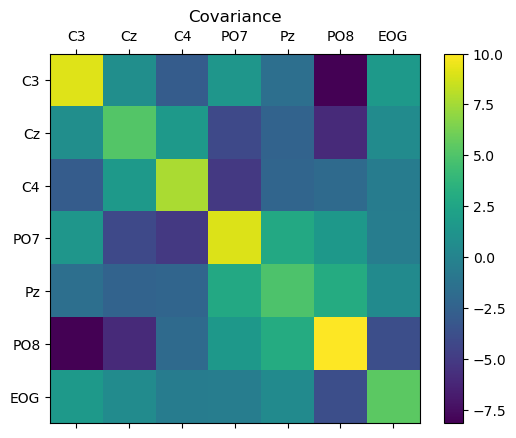

,C3,Cz,C4,PO7,Pz,PO8,EOG
C3,9.135905,0.800698,-2.853013,1.353761,-1.524789,-8.145472,1.587660
Cz,0.800698,5.140300,1.622676,-4.123699,-2.371759,-5.977565,0.604683
C4,-2.853013,1.622676,7.701769,-5.150303,-2.234499,-1.886810,-0.511384
PO7,1.353761,-4.123699,-5.150303,9.054611,2.836721,1.548093,-0.423719
Pz,-1.524789,-2.371759,-2.234499,2.836721,4.902479,3.029790,0.550912
PO8,-8.145472,-5.977565,-1.886810,1.548093,3.029790,19.613385,-3.815619
EOG,1.587660,0.604683,-0.511384,-0.423719,0.550912,-3.815619,5.460045


In [363]:
df = epochs.to_data_frame()
df_numerical = df[epochs.ch_names]

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(df_numerical.cov(), interpolation='nearest',vmax=10)
fig.colorbar(cax)

alpha = epochs.ch_names
ax.set_xticklabels(['']+alpha)
ax.set_yticklabels(['']+alpha)
ax.set_title('Covariance')

plt.show()
df_numerical.cov()

In [364]:
df_numerical.corr()['EOG'][:-1].mul(df_numerical.std().iloc[:-1]/df_numerical.std().iloc[-1])

C3     0.290778
Cz     0.110747
C4    -0.093659
PO7   -0.077604
Pz     0.100899
PO8   -0.698826
dtype: float64

### 2.1 Visualize Original Data

#### Signal Average Over Epochs

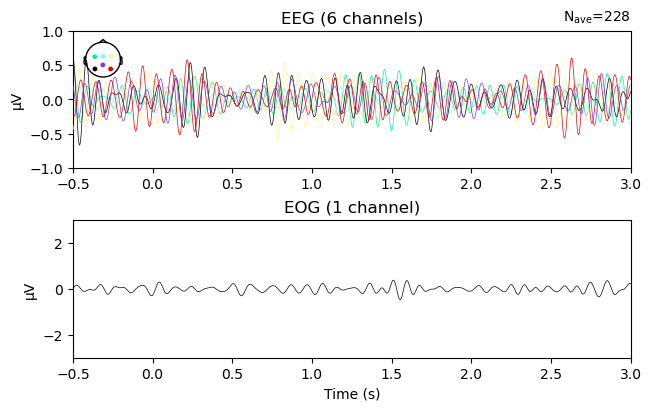

In [365]:
plot_kwargs = dict(picks="all", ylim=dict(eeg=(-1, 1), eog=(-3, 3)))

# plot the evoked for the EEG and the EOG sensors
fig = epochs.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

#### Time Domain Plot

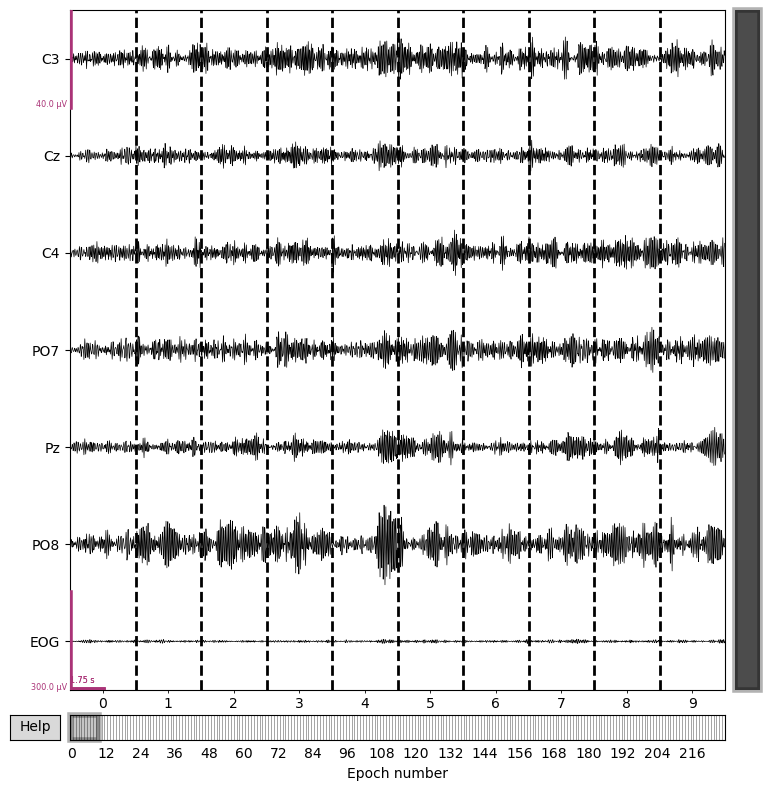

In [366]:
epochs.plot(picks='all', n_epochs=10);

### 2.2 Compute and Apply EOG Regression

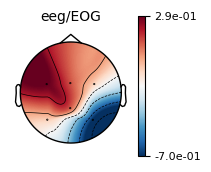

In [367]:
# Perform regression using the EOG sensor as independent variable and the EEG
# sensors as dependent variables.
model_plain = EOGRegression(picks="eeg", picks_artifact="eog").fit(epochs)

epochs_clean_plain = model_plain.apply(epochs)
# After regression, we should redo the baseline correction
epochs_clean_plain.apply_baseline()

fig = model_plain.plot()  # regression coefficients as topomap
fig.set_size_inches(3, 2)

In [368]:
model_plain.coef_

array([[ 0.29069205],
       [ 0.11065661],
       [-0.09344285],
       [-0.07763291],
       [ 0.10112503],
       [-0.69901226]])

#### Signal Average Over Epochs

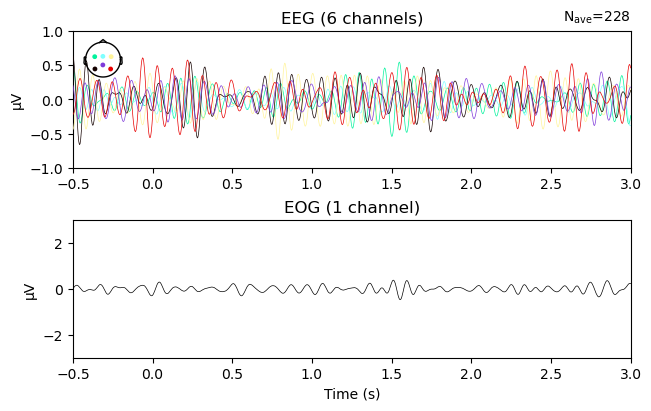

In [369]:
# Show the evoked potential computed on the corrected data
fig = epochs_clean_plain.average("all").plot(**plot_kwargs)
fig.set_size_inches(6, 6)

#### Time Domain Plot

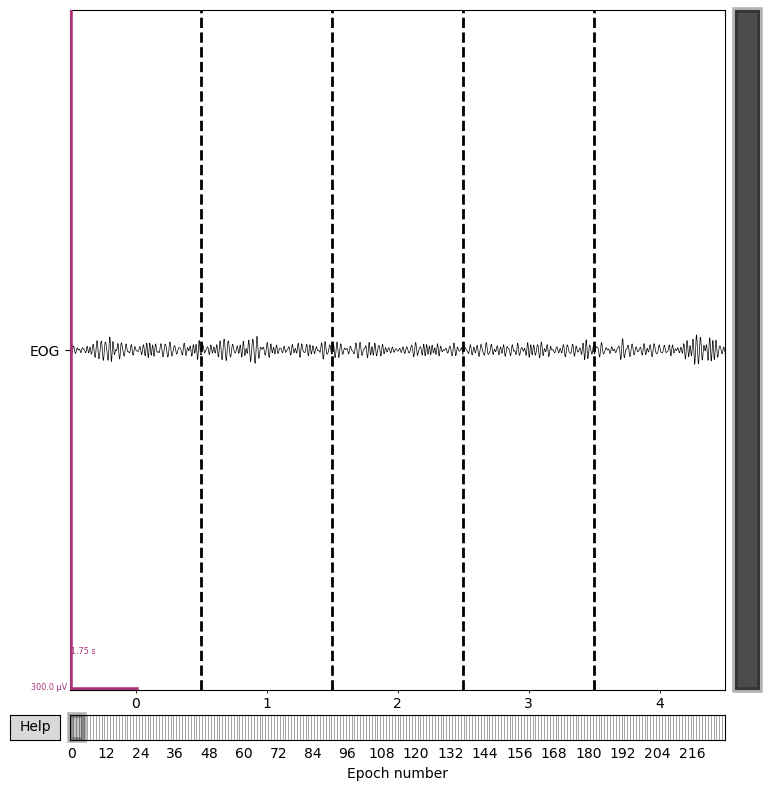

In [370]:
epochs_clean_plain.plot(picks='EOG', n_epochs=5);

### 2.3 Left vs. Right Classification

#### 2.3.1 SVM

Train set shape: (120, 7)
Test set shape : (30, 7)


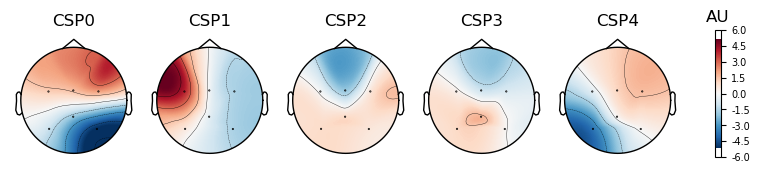

Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

       right       0.92      0.73      0.81        15
        left       0.78      0.93      0.85        15

    accuracy                           0.83        30
   macro avg       0.85      0.83      0.83        30
weighted avg       0.85      0.83      0.83        30



In [371]:
# Get EEG data and events
X = epochs_clean_plain[['right','left']].get_data(copy=False)
Y = epochs_clean_plain[['right','left']].events[:, -1]

csp_list = []
svm_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    svm = Pipeline([('SVM', SVC(kernel='linear'))])  
    svm.fit(X_train, Y_train)
    svm_list.append(svm)

    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['right', 'left'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

#### 2.3.2 Logistic Regression

Train set shape: (120, 7)
Test set shape : (30, 7)


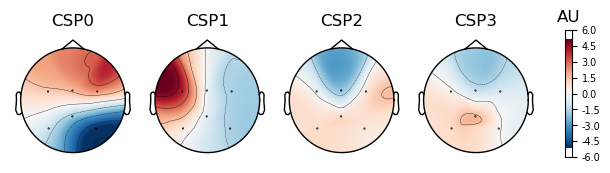

Accuracy: 0.8333333333333334
              precision    recall  f1-score   support

  none-right       0.92      0.73      0.81        15
       right       0.78      0.93      0.85        15

    accuracy                           0.83        30
   macro avg       0.85      0.83      0.83        30
weighted avg       0.85      0.83      0.83        30



In [372]:
csp_list = []
lr_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    lr = Pipeline([('LR', LogisticRegression())])
    lr.fit(X_train, Y_train)
    lr_list.append(lr)

    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
lr = lr_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

### 2.4 Left vs. Non-left Classification

#### 2.4.1 SVM

Train set shape: (182, 7)
Test set shape : (46, 7)


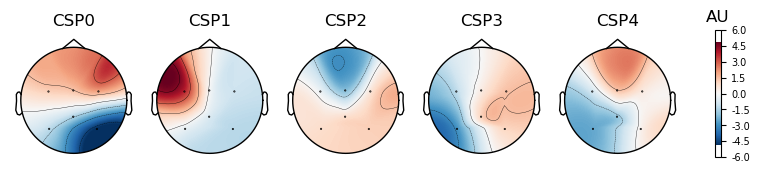

Accuracy: 0.8043478260869565
              precision    recall  f1-score   support

   none-left       0.82      0.90      0.86        31
        left       0.75      0.60      0.67        15

    accuracy                           0.80        46
   macro avg       0.79      0.75      0.76        46
weighted avg       0.80      0.80      0.80        46



In [373]:
epochs_clean_plain_l = epochs_clean_plain.copy()
epochs_clean_plain_l.events = mne.merge_events(epochs_clean_plain_l.events, [0, 1], 0, replace_events=True)
epochs_clean_plain_l.event_id = {'none-left': 0, 'left': 2}

# Get EEG data and events
X = epochs_clean_plain_l.get_data(copy=False)
Y = epochs_clean_plain_l.events[:, -1]

csp_list = []
svm_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    svm = Pipeline([('SVM', SVC(kernel='linear'))])  
    svm.fit(X_train, Y_train)
    svm_list.append(svm)

    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-left', 'left'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

#### 2.4.2 Logistic Regression

Train set shape: (182, 7)
Test set shape : (46, 7)


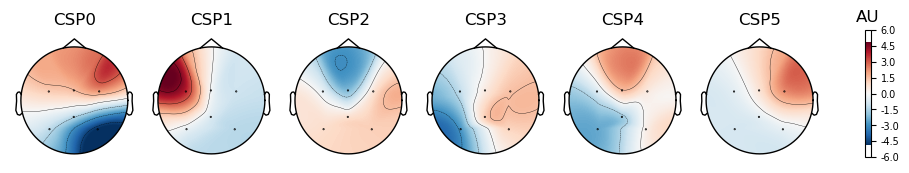

Accuracy: 0.8478260869565217
              precision    recall  f1-score   support

  none-right       0.85      0.94      0.89        31
       right       0.83      0.67      0.74        15

    accuracy                           0.85        46
   macro avg       0.84      0.80      0.82        46
weighted avg       0.85      0.85      0.84        46



In [374]:
csp_list = []
lr_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    lr = Pipeline([('LR', LogisticRegression())])
    lr.fit(X_train, Y_train)
    lr_list.append(lr)

    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
lr = lr_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

### 2.5 Right vs. Non-Right Classification

#### 2.5.1 SVM

Train set shape: (182, 7)
Test set shape : (46, 7)


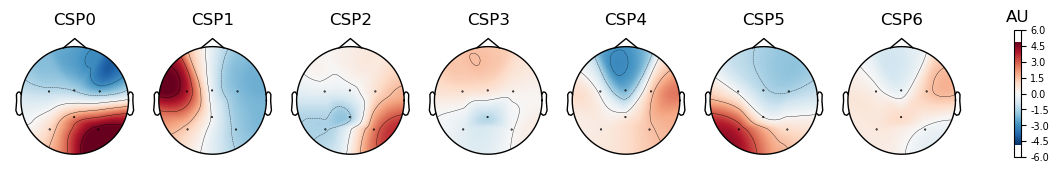

Accuracy: 0.782608695652174
              precision    recall  f1-score   support

  none-right       0.78      0.94      0.85        31
       right       0.78      0.47      0.58        15

    accuracy                           0.78        46
   macro avg       0.78      0.70      0.72        46
weighted avg       0.78      0.78      0.77        46



In [375]:
epochs_clean_plain_r = epochs_clean_plain.copy()
epochs_clean_plain_r.events = mne.merge_events(epochs_clean_plain_r.events, [0, 2], 0, replace_events=True)
epochs_clean_plain_r.event_id = {'none-right': 0, 'right': 1}

# Get EEG data and events
X = epochs_clean_plain_r.get_data(copy=False)
Y = epochs_clean_plain_r.events[:, -1]

csp_list = []
svm_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    svm = Pipeline([('SVM', SVC(kernel='linear'))])  
    svm.fit(X_train, Y_train)
    svm_list.append(svm)

    y_pred = svm.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
svm = svm_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])

#### 2.5.2 Logistic Regression

Train set shape: (182, 7)
Test set shape : (46, 7)


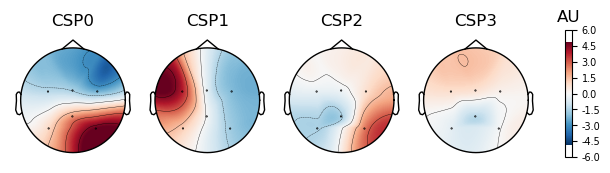

Accuracy: 0.7391304347826086
              precision    recall  f1-score   support

  none-right       0.77      0.87      0.82        31
       right       0.64      0.47      0.54        15

    accuracy                           0.74        46
   macro avg       0.70      0.67      0.68        46
weighted avg       0.73      0.74      0.73        46



In [376]:
csp_list = []
lr_list = []
acc_list = []
report_list = []

for i in range(2, len(epochs.ch_names) + 1):
    # -- |Features Extraction| --
    # Initilize CSP
    csp = CSP(n_components = i, norm_trace = False)

    # Fit CSP to data 
    csp.fit(X,Y)
    csp_list.append(csp)

    # Transform data into CSP space
    X_transformed = csp.transform(X)

    # -- |Classification| --
    # Split data into training and test sets
    X_train, X_test, Y_train, Y_test = train_test_split(X_transformed, Y, test_size = 0.2, random_state = 42, stratify=Y)

    # Classification 
    lr = Pipeline([('LR', LogisticRegression())])
    lr.fit(X_train, Y_train)
    lr_list.append(lr)

    y_pred = lr.predict(X_test)
    accuracy = accuracy_score(Y_test, y_pred)
    acc_list.append(accuracy)

    report = classification_report(Y_test, y_pred, target_names=['none-right', 'right'])  # adjust target names accordingly
    report_list.append(report)

# -- |Select CSP which gives maximum accuracy| --
ind = np.argmax(acc_list) 

# -- |Print Data Shape| --
print(f'Train set shape: {X_train.shape}')
print(f'Test set shape : {X_test.shape}')

# -- |Visualize CSP patterns| --
csp = csp_list[ind]
csp.plot_patterns(epochs.info);

# -- |Classification results| --
lr = lr_list[ind]
print(f"Accuracy: {acc_list[ind]}")
print(report_list[ind])